<h1>K-Means Clustering</h1>

<h5>Importing Packages</h5>

In [0]:
try:
    from google.colab import drive
    drive.mount('/drive', force_remount=False)
    %run "/drive/My Drive/Colab Notebooks/Notebooks/Classical Machine Learning/Classical Methods - Processing.ipynb"
except:
    %run "/Google Drive/My Drive/Colab Notebooks/Notebooks/Classical Machine Learning/Classical Methods - Processing.ipynb"

<h5>Parameters</h5>

In [0]:
datasets = getDataSets()

In [0]:
sides = ['left', 'right']
n_clusters = 3
window_sizes = [100, 150, 200, 250, 300]
window_fn = experiment_by_window_fn[0]
agg_fn_dict = experiment_by_agg_fn[5]
fields = experiment_by_fields[2]
agg_fn = getAggFunctions(fields, acc=agg_fn_dict["acc"], gyro=agg_fn_dict["gyro"], speed=agg_fn_dict["speed"])
save_path = os.path.join(work_folder, "KMC")
createPathIfNotExists(save_path)
subsets = getSubSets(datasets.copy(), fields, surface_type_labels)

<h5>Execution</h5>

In [0]:
def searchBestModel(subsets, sets_train, sets_test, experiment_number, experiment_load_bar):
     
    execution_log = []
    experiment_path = os.path.join(save_path, "Experiment " + str(experiment_number)) 
    
    for window in window_sizes:
        
        features_set = getExtractedFeatures(subsets, window_fn, window, agg_fn, sides)
        input_train, input_test, output_train, output_test = getTrainTestSets(features_set, sets_train, sets_test, sides)

        best_model = None

        for i in range(0, 3):         
            model, train_acc, val_acc = trainTestModel(input_train, input_test, output_train, output_test)
            new_model = (model, { "window": window, "clusters": n_clusters }, train_acc, val_acc)
            best_model = compareBestModel(best_model, new_model)
        
        execution_log.append([experiment_number, window, n_clusters, best_model[2], best_model[3]])

        file_prefix = "experiment-" + str(experiment_number) + "-window-" + str(window) + "-clusters-" + str(n_clusters)
        saveBestModel(experiment_path, file_prefix, best_model)

        experiment_load_bar.update(1)
        print("Experiment", str(experiment_number), "Window", str(window), "Clusters", str(n_clusters), "Train Acc", str(best_model[2]), "Val Acc", best_model[3])
    
    saveExecutionLog(experiment_path, "experiment", execution_log, ["experiment", "window", "clusters", "train_acc", "val_acc"])
           
def trainTestModel(x_train, x_test, y_train, y_test):
    
    # Build model
    model = KMeans(n_clusters=n_clusters, verbose=1, n_jobs=-1, max_iter=100000)
    
    # Fit model
    model.fit(x_train.values)
    
    # Test model
    y_train_pred = model.predict(x_train.values) 
    y_test_pred = model.predict(x_test.values) 

    return model, accuracy(y_train, y_train_pred, model), accuracy(y_test, y_test_pred, model)

def accuracy(y_true, y_pred, model):

    # Match clusters (from k means) with labels (from dataset)
    y_true = y_true.copy().values.argmax(axis=1)

    labels = np.zeros_like(y_pred)

    for i in range(model.n_clusters):
        mask = (y_pred == i)
        labels[mask] = mode(y_true[mask])[0]

    return accuracy_score(y_true, labels)

def run():
    
    experiment_total_iteration = len(window_sizes)
    experiment_total = len(experiment_by_dataset)
    
    load_bar_main = tqdm(total=experiment_total, desc='Main Progress')
    load_bar_experiment = tqdm(total=experiment_total_iteration)
    
    experiment_number = 0
  
    for dataset_dict in experiment_by_dataset:
        experiment_number += 1
        load_bar_experiment.reset()
        load_bar_experiment.set_description("Experiment " + str(experiment_number))
        searchBestModel(subsets, dataset_dict["train"], dataset_dict["test"], experiment_number, load_bar_experiment)
        load_bar_main.update(1)

In [0]:
run()

<h5>Best Model - Confusion Matrix</h5>

In [0]:
files = [
    'experiment-1-window-300-clusters-3-train-acc-0.6053310404-val-acc-0.6567164179.joblib',
    'experiment-2-window-300-clusters-3-train-acc-0.560409699-val-acc-0.6031483016.joblib',
    'experiment-3-window-300-clusters-3-train-acc-0.5813316477-val-acc-0.5526101142.joblib'
]

0.6567164179104478
0.6031483015741508
0.552610114192496


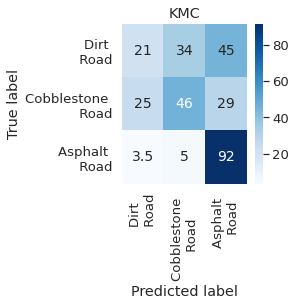

In [9]:
matrix = []
window = 300

for experiment_number in range(0,3):

    sets_train = experiment_by_dataset[experiment_number]['train']
    sets_test = experiment_by_dataset[experiment_number]['test']

    features_set = getExtractedFeatures(subsets, window_fn, window, agg_fn, sides)
    input_train, input_test, output_train, output_test = getTrainTestSets(features_set, sets_train, sets_test, sides)

    path = os.path.join(work_folder, "KMC", "Experiment " + str(experiment_number + 1))
    model = loadBestModel(path, files[experiment_number])[0]
    y_pred = model.predict(input_test.values) 

    # Match clusters (from k means) with labels (from dataset)
    y_true = output_test.copy().values.argmax(axis=1)

    labels = np.zeros_like(y_pred)

    for i in range(model.n_clusters):
        mask = (y_pred == i)
        labels[mask] = mode(y_true[mask])[0]

    print(accuracy_score(y_true, labels))
    matrix.append(confusion_matrix(y_true, labels, normalize="true"))

result = ((matrix[0] + matrix[1] + matrix[2])/3)*100
plotConfusionMatrix(result, "KMC")